# Hej Søren

Her er en notebook du kan køre. Den finder sammenhængende omåder på chrX som i som enten er ren olive ancestry eller 95% hamadryas ancestry. Prøv om du kan finde overlap til dit round spermatid hic map.

VH Kasper

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from os.path import expanduser
%config InlineBackend.figure_format = 'svg'

sns.set()
sns.set_style("ticks")

def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')
    
def add_band(x_low, x_high, y_low=None, y_high=None, ax=None, color='gray', linewidth=0, alpha=0.5, zorder=0, **kwargs):
    "Plot a gray block on x interval"
    if ax is None:
        ax = plt.gca()
    if y_low is None:
        y_low, _ = ax.get_ylim()
    if y_high is None:
        _, y_high = ax.get_ylim()
    g = ax.add_patch(Rectangle((x_low, y_low), x_high-x_low, y_high-y_low, 
                 facecolor=color,
                 linewidth=linewidth,
                 alpha=alpha,
                 zorder=zorder,
                 **kwargs))

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

In [7]:
meta_data_samples = pd.read_csv(expanduser("~/baboondiversity/people/kmt/baboons/data/Papio_metadata_with_clustering.txt"), sep =" ")
gog_olives = meta_data_samples.loc[meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia", :].PGDP_ID

#mean_window_df_tanz = pd.read_hdf('~/baboondiversity/people/kmt/baboons/results/mean_window_df_tanz.h5')
mean_window_df_eth = pd.read_hdf('~/baboondiversity/people/kmt/baboons/results/mean_window_df_eth.h5')

window_means_gog = mean_window_df_eth.loc[mean_window_df_eth.individual.isin(gog_olives), :].groupby(['chrom', 'start', 'end']).north_sum.mean().to_frame().reset_index()
chrX_window_means_gog = window_means_gog.loc[window_means_gog.chrom == 'all_chrX', :].copy()
chrX_window_means_gog.head()

,chrom,start,end,north_sum
0,all_chrX,0,100000,0.0
1,all_chrX,100000,200000,0.0
2,all_chrX,200000,300000,0.0
3,all_chrX,300000,400000,0.0
4,all_chrX,400000,500000,0.0


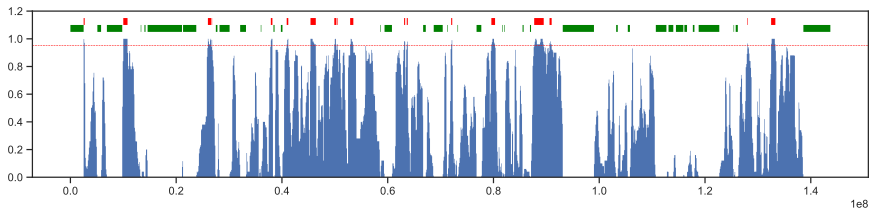

In [12]:
def get_runs(df, fun):
    df = df.copy()
    df.loc[:, 'label'] = fun(df)
    df.loc[:, 'run'] = (df.label != df.label.shift()).cumsum()
    df = (df
           .loc[df.label]
           .groupby('run')
           .apply(lambda df: pd.DataFrame(dict(start=[df.start.min()], end=[df.end.max()])))
           )
    df['length'] = df.end - df.start
    return df

cut = 95000

high_hama = get_runs(chrX_window_means_gog, fun=lambda df: df.north_sum >= cut)
high_olive = get_runs(chrX_window_means_gog, fun=lambda df: df.north_sum == 0)

plot_df = stairs(chrX_window_means_gog)
plt.figure(figsize=(15, 3))
plt.fill_between(plot_df.pos, plot_df.north_sum/100_000, ec='none')
plt.axhline(cut/100000, linestyle='dashed', color='red', linewidth=0.5)
plt.ylim(0, 1.2)
[add_band(tup.start, tup.end, 1.1, 1.15, color='red', alpha=1) for tup in high_hama[['start', 'end']].itertuples()] ;
[add_band(tup.start, tup.end, 1.05, 1.1, color='green', alpha=1) for tup in high_olive[['start', 'end']].itertuples()] ;

In [9]:
high_hama.head()

,,start,end,length
run,,,,
2,0,2500000,2700000,200000
4,0,10000000,10800000,800000
6,0,26000000,26600000,600000
8,0,26700000,26800000,100000
10,0,37900000,38200000,300000


In [32]:
high_olive.head()

,,start,end,length
run,,,,
1,0,0,2500000,2500000
3,0,5100000,5800000,700000
5,0,6900000,9800000,2900000
7,0,13300000,13400000,100000
9,0,14000000,14200000,200000
